In [1]:
import os, zipfile, glob
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
ZIP_PATH =  "/all_kindle_review .csv.zip" # path to your uploaded ZIP
CSV_NAME_CANDIDATES = ["all_kindle_review.csv", "reviews.csv"]  # common names
POPULAR_THRESHOLD = 4            # rating >= threshold => popular
SAMPLE_N = None                  # set to an int to subsample (None = use all)
RANDOM_STATE = 42
TEST_SIZE = 0.2
TFIDF_MAX_FEATURES = 20000
TFIDF_NGRAM_RANGE = (1,2)
RUN_RANDOM_FOREST = True
RUN_GBDT = True
RUN_LOGISTIC = True
RUN_SVM = True
def extract_zip_if_needed(zip_path):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found at {zip_path}")
    extract_dir = os.path.splitext(zip_path)[0] + "_extracted"
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)
    return extract_dir

extract_dir = extract_zip_if_needed(ZIP_PATH)
csv_files = glob.glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True)
if not csv_files:
    raise SystemExit("No CSV file found inside zip.")
print("Found CSV files:", csv_files)

Found CSV files: ['/all_kindle_review .csv_extracted/all_kindle_review .csv']


In [6]:
# 2) Pick CSV
csv_path = None
for cand in CSV_NAME_CANDIDATES:
    for p in csv_files:
        if os.path.basename(p).lower() == cand.lower():
            csv_path = p
            break
    if csv_path: break
if csv_path is None:
    csv_path = csv_files[0]
print("Using CSV:", csv_path)

# 3) Load CSV
def try_read_csv(path, nrows=None):
    encs = ['utf-8', 'latin1', 'cp1252']
    for e in encs:
        try:
            return pd.read_csv(path, encoding=e, nrows=nrows, low_memory=False)
        except:
            continue
    return pd.read_csv(path, engine='python', encoding='utf-8', nrows=nrows, on_bad_lines='skip')

df = try_read_csv(csv_path, nrows=SAMPLE_N)
print("Loaded dataframe shape:", df.shape)
print("Columns:", df.columns.tolist())


Using CSV: /all_kindle_review .csv_extracted/all_kindle_review .csv
Loaded dataframe shape: (12000, 11)
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'asin', 'helpful', 'rating', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime']


In [7]:
# 4) Identify text and rating columns
def find_col(cols, candidates):
    low = [c.lower() for c in cols]
    for cand in candidates:
        if cand in low:
            return cols[low.index(cand)]
    for cand in candidates:
        for c in cols:
            if cand in c.lower():
                return c
    return None

text_candidates = ['review', 'review_text', 'reviewtext', 'text', 'reviewbody', 'review_body', 'body']
rating_candidates = ['rating','overall','stars','score','star_rating']

text_col = find_col(df.columns.tolist(), text_candidates)
rating_col = find_col(df.columns.tolist(), rating_candidates)

if text_col is None:
    obj_cols = [c for c in df.columns if df[c].dtype == object]
    lengths = {c: df[c].dropna().astype(str).map(len).mean() for c in obj_cols}
    text_col = max(lengths, key=lengths.get)
    print("Heuristic chose text col:", text_col)
else:
    print("Detected text column:", text_col)

if rating_col is None:
    raise SystemExit("Rating column missing.")
else:
     print("Detected rating column:", rating_col)

Detected text column: reviewText
Detected rating column: rating


In [8]:
# 5) Keep only needed columns and drop NA
df = df[[text_col, rating_col]].dropna().rename(columns={text_col: 'review_text', rating_col: 'rating'})
df['review_text'] = df['review_text'].astype(str).str.strip()
df = df[df['review_text'].str.len() > 10].reset_index(drop=True)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df[df['rating'].notnull()]
df['popular'] = (df['rating'] >= POPULAR_THRESHOLD).astype(int)
print("Label counts:\n", df['popular'].value_counts())

# 6) Train/test split
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['popular'],
                                                    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['popular'])
print("Train/test sizes:", X_train.shape, X_test.shape)

# 7) TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=TFIDF_NGRAM_RANGE, min_df=3)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


Label counts:
 popular
0    5999
1    5996
Name: count, dtype: int64
Train/test sizes: (9596,) (2399,)
TF-IDF shapes: (9596, 20000) (2399, 20000)


In [9]:
# 8) Evaluation function
def eval_and_print(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 9) Train models with GridSearchCV
models = {}

# Hyperparameter grids
lr_params = {'C': [0.01, 0.1, 1, 10]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [20, 30, None]}
svm_params = {'C': [0.01, 0.1, 1, 10]}
gbdt_params = {'max_iter': [100, 200], 'max_depth': [3, 5, 10], 'learning_rate': [0.05, 0.1, 0.2]}



Training LogisticRegression with GridSearchCV...
Best LR params: {'C': 10}

=== LogisticRegression Evaluation ===
Accuracy: 0.8516048353480616
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1200
           1       0.85      0.85      0.85      1199

    accuracy                           0.85      2399
   macro avg       0.85      0.85      0.85      2399
weighted avg       0.85      0.85      0.85      2399



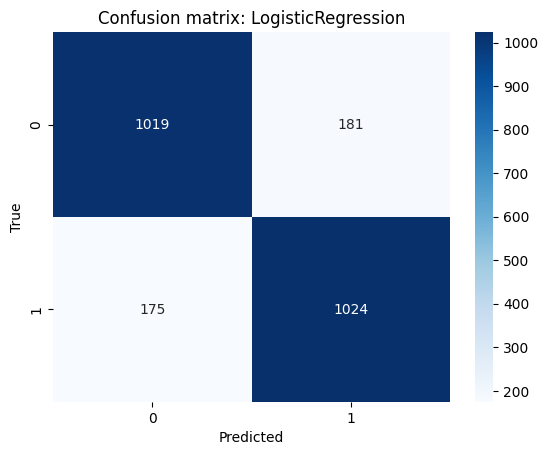

In [10]:
# Logistic Regression
if RUN_LOGISTIC:
    print("\nTraining LogisticRegression with GridSearchCV...")
    lr_grid = GridSearchCV(LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE),
                           param_grid=lr_params, scoring='f1', cv=3, n_jobs=-1)
    lr_grid.fit(X_train_tfidf, y_train)
    models['logistic'] = lr_grid.best_estimator_
    print("Best LR params:", lr_grid.best_params_)
    eval_and_print("LogisticRegression", models['logistic'], X_test_tfidf, y_test)


Training RandomForest with GridSearchCV...
Best RF params: {'max_depth': 30, 'n_estimators': 200}

=== RandomForest Evaluation ===
Accuracy: 0.8115881617340559
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1200
           1       0.83      0.79      0.81      1199

    accuracy                           0.81      2399
   macro avg       0.81      0.81      0.81      2399
weighted avg       0.81      0.81      0.81      2399



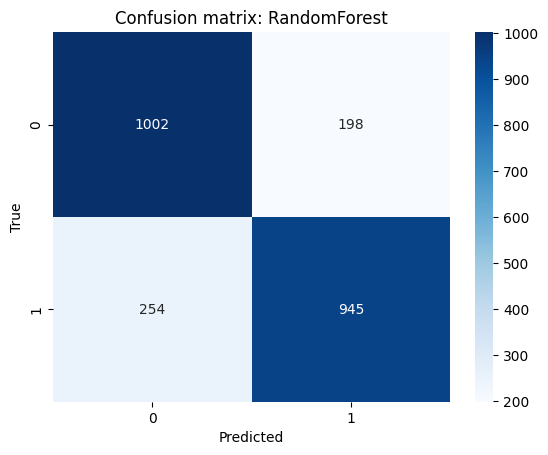

In [11]:
# Random Forest
if RUN_RANDOM_FOREST:
    print("\nTraining RandomForest with GridSearchCV...")
    rf_grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
                           param_grid=rf_params, scoring='f1', cv=3)
    rf_grid.fit(X_train_tfidf, y_train)
    models['random_forest'] = rf_grid.best_estimator_
    print("Best RF params:", rf_grid.best_params_)
    eval_and_print("RandomForest", models['random_forest'], X_test_tfidf, y_test)


Training LinearSVC with GridSearchCV...
Best SVM params: {'C': 1}

=== LinearSVC Evaluation ===
Accuracy: 0.8453522300958732
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1200
           1       0.84      0.85      0.85      1199

    accuracy                           0.85      2399
   macro avg       0.85      0.85      0.85      2399
weighted avg       0.85      0.85      0.85      2399



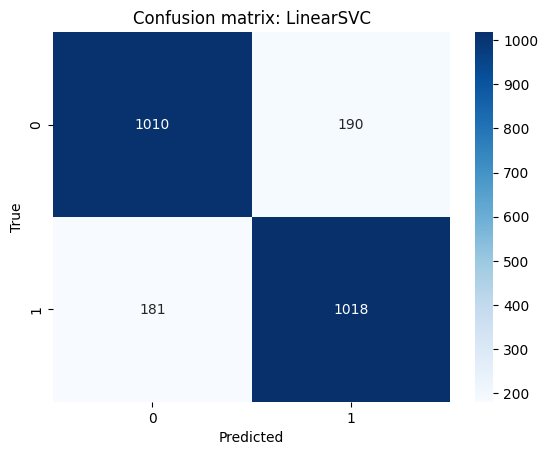

In [12]:
# SVM (LinearSVC)
if RUN_SVM:
    print("\nTraining LinearSVC with GridSearchCV...")
    svm_grid = GridSearchCV(LinearSVC(class_weight='balanced', max_iter=10000, random_state=RANDOM_STATE),
                            param_grid=svm_params, scoring='f1', cv=3)
    svm_grid.fit(X_train_tfidf, y_train)
    models['svm'] = svm_grid.best_estimator_
    print("Best SVM params:", svm_grid.best_params_)
    eval_and_print("LinearSVC", models['svm'], X_test_tfidf, y_test)


Training HistGradientBoosting with GridSearchCV (on SVD-reduced features)...
Best GBDT params: {'learning_rate': 0.2, 'max_depth': 3, 'max_iter': 200}

=== HistGradientBoosting Evaluation ===
Accuracy: 0.8007503126302626
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1200
           1       0.81      0.79      0.80      1199

    accuracy                           0.80      2399
   macro avg       0.80      0.80      0.80      2399
weighted avg       0.80      0.80      0.80      2399



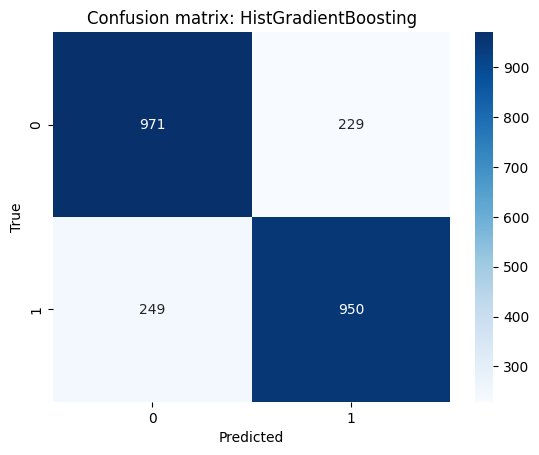

In [13]:

# Gradient Boosting
if RUN_GBDT:
    print("\nTraining HistGradientBoosting with GridSearchCV (on SVD-reduced features)...")
    svd_dim = 200
    svd = TruncatedSVD(n_components=svd_dim, random_state=RANDOM_STATE)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)
    gbdt_grid = GridSearchCV(HistGradientBoostingClassifier(random_state=RANDOM_STATE),
                             param_grid=gbdt_params, scoring='f1', cv=3)
    gbdt_grid.fit(X_train_svd, y_train)
    models['gbdt'] = (gbdt_grid.best_estimator_, svd)
    print("Best GBDT params:", gbdt_grid.best_params_)
    eval_and_print("HistGradientBoosting", gbdt_grid.best_estimator_, X_test_svd, y_test)

In [14]:
# 10) Feature importance (LR & RF)
def show_top_text_features(tfidf_vect, model, topk=20):
    feat_names = np.array(tfidf_vect.get_feature_names_out())
    if isinstance(model, LogisticRegression):
        coefs = model.coef_[0]
        top_pos = feat_names[np.argsort(coefs)[-topk:]][::-1]
        top_neg = feat_names[np.argsort(coefs)[:topk]]
        print("Top positive features (predict popular):", top_pos.tolist())
        print("Top negative features (predict not popular):", top_neg.tolist())
    elif isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_
        top_idx = np.argsort(importances)[-topk:][::-1]
        print("Top RF features (by importance):", feat_names[top_idx].tolist())

if RUN_LOGISTIC:
    show_top_text_features(tfidf, models['logistic'])
if RUN_RANDOM_FOREST:
    show_top_text_features(tfidf, models['random_forest'])

Top positive features (predict popular): ['loved', 'enjoyed', 'great', 'well', 'loved this', 'wonderful', 'loved it', 'perfect', 'highly', 'excellent', 'very good', 'amazing', 'hot', 'enjoyed this', 'well done', 'awesome', 'great book', 'loving', 'coming', 'wait to']
Top negative features (predict not popular): ['not', 'okay', 'boring', 'nothing', 'just', 'waste', 'for me', 'no', 'sorry', 'ok', 'disappointing', 'not worth', 'didn', 'poorly', 'sex', 'wouldn', 'it just', 'bad', 'pages', 'at all']
Top RF features (by importance): ['not', 'was', 'enjoyed', 'great', 'just', 'loved', 'didn', 'series', 'it', 'but', 'love', 'bad', 'and', 'no', 'read', 'free', 'waste', 'it was', 'well', 'for me']


In [15]:
# 11) Save models
out_dir = "/content/sample_data"
os.makedirs(out_dir, exist_ok=True)
if 'logistic' in models:
    joblib.dump(models['logistic'], os.path.join(out_dir, "logistic_model.joblib"))
if 'random_forest' in models:
    joblib.dump(models['random_forest'], os.path.join(out_dir, "random_forest_model.joblib"))
if 'svm' in models:
    joblib.dump(models['svm'], os.path.join(out_dir, "svm_model.joblib"))
if 'gbdt' in models:
    joblib.dump(models['gbdt'][0], os.path.join(out_dir, "gbdt_model.joblib"))
    joblib.dump(models['gbdt'][1], os.path.join(out_dir, "gbdt_svd.joblib"))
joblib.dump(tfidf, os.path.join(out_dir, "tfidf_vectorizer.joblib"))
print("Saved models to", out_dir)

print("\nDone. All models trained, evaluated, and saved.")

Saved models to /content/sample_data

Done. All models trained, evaluated, and saved.
